# Tool Architecture

Contextualizing the problem in ML
To contextualize the problem, this has been divided into goals, each goal contextualized in a different area of requirements engineering.
- Goal 1.	Support Change-Impact Analysis.
- Goal 2.	Domain mapping and ontology creation.
    - a.	Requirement analysis.
- Goal 3.	Trace or elicit safety-related aspects from existing norms and standards.
    - a.	Requirement elicitation.
- Goal 4.	Facilitating effective tracing, reuse, and analysis of system requirements to prevent safety violations.
    - a.	Classify safety violations.


## Import Data

The dataset originates from PURE, a requirements collection formatted in XML. All XML files share a standard namespace called 'req_document.xsd,' simplifying the development of a function to parse the XML files into a dataframe. This dataframe includes columns for the relevant XML tags, indicating whether the text corresponds to a requirement or information, the XML tree of the entry (or path), and the associated ID, that stands for the requirement number.

TODO: 
- Missing test of quality with other sources
- Import all in folder into instances of classes


In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import string
import re
import nltk
import pprint
from utils import parse_xml

print(sys.version)
print(sys.executable)


# Specify the path to your XML filec
xml_file_path = r'C:\dev\NLP-Sandbox\PURE\requirements-xml\0000 - cctns.xml'

# Define the namespace
namespace = {'ns': 'req_document.xsd'}

# import utils.ParseXML as ParseXML
df = parse_xml.process_xml_with_namespace(xml_file_path, namespace)
df.head(30)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
c:\ProgramData\anaconda3\python.exe


,tag,text,id,path
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title
4,version,1.0,,req_document/version
5,title,INTRODUCTION,1,req_document/p/title
6,title,The Functional Requirements Specifications (FR...,,req_document/p/text_body
7,title,FUNCTIONAL OVERVIEW,2,req_document/p/title
8,title,CCTNS V1.0 functionality is designed to focus ...,,req_document/p/text_body
9,title,DESCRIPTION OF THE MODULES AND FUNCTIONAL REQU...,3,req_document/p/title


## Clean Data
Having retrieved the text in the XML file to a workable format (dataframes), it is necessary to cleanup and tokenize the text.
This is not as straightforward as it might seem since care is needed to preserve special words such as those separated by hyphens (e-governance, non-functional, …). 


First, let’s tokenize the documents, remove common words as well as words that only appear once in the corpus:

### Remove punctiation, Tokenization and remove stopwords


In [2]:
from utils import clean_data

clean_data_case = "lsa_preprocess"

if clean_data_case == "lsa_preprocess":
    df['text_clean'] = df['text'].apply(lambda x: clean_data.preprocess_data_str(x))
else:
    df['text_clean'] = df['text'].apply(lambda x: clean_data.clean_text(x.lower(),False,False))

# Display the sub-dataframe
df.head()

,tag,text,id,path,text_clean
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title,"[e, govern, mission, mode, project, mmp]"
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title,"[crime, crimin, track, network, system, cctn]"
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title,"[function, requir, specif, v1, 0, draft]"
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title,"[ministri, home, affair, govern, india]"
4,version,1.0,,req_document/version,"[1, 0]"


### POS Tagging

In [3]:
import spacy
from spacy import displacy
from nltk import word_tokenize

text = "This is one simple example."
tokens = word_tokenize(text)
tags = nltk.pos_tag(tokens, tagset = "universal")
#print(tags)

df['POS'] = df['text'].apply(lambda x: nltk.pos_tag(word_tokenize(x.lower()), tagset = "universal"))

display(df.head(40))

# Display phrase and the POS tag and relationship
if False:
    nlp = spacy.load("en_core_web_sm")
    for line in df["text"]:
        doc = nlp(line)
        options = {"compact": True, "color": "blue"}
        displacy.render(doc, style = "dep",options=options, jupyter=True)
    pass

,tag,text,id,path,text_clean,POS
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title,"[e, govern, mission, mode, project, mmp]","[(e-governance, ADJ), (mission, NOUN), (mode, ..."
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title,"[crime, crimin, track, network, system, cctn]","[(crime, NOUN), (&, CONJ), (criminal, ADJ), (t..."
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title,"[function, requir, specif, v1, 0, draft]","[(functional, ADJ), (requirements, NOUN), (spe..."
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title,"[ministri, home, affair, govern, india]","[(ministry, NOUN), (of, ADP), (home, NOUN), (a..."
4,version,1.0,,req_document/version,"[1, 0]","[(1.0, NUM)]"
5,title,INTRODUCTION,1,req_document/p/title,[introduct],"[(introduction, NOUN)]"
6,title,The Functional Requirements Specifications (FR...,,req_document/p/text_body,"[function, requir, specif, fr, report, provid,...","[(the, DET), (functional, ADJ), (requirements,..."
7,title,FUNCTIONAL OVERVIEW,2,req_document/p/title,"[function, overview]","[(functional, ADJ), (overview, NOUN)]"
8,title,CCTNS V1.0 functionality is designed to focus ...,,req_document/p/text_body,"[cctn, v1, 0, function, design, focu, deliv, v...","[(cctns, NOUN), (v1.0, NOUN), (functionality, ..."
9,title,DESCRIPTION OF THE MODULES AND FUNCTIONAL REQU...,3,req_document/p/title,"[descript, modul, function, requir]","[(description, NOUN), (of, ADP), (the, DET), (..."


# Concordance / Ontology

GOALS:
- User curated onthology of special terms in context of the requirements domain

A concordance is an alphabetical list of the principal words used in a book or body of work, listing every instance of each word with its immediate context. Historically, concordances have been compiled only for works of special importance, such as the Vedas,[1] Bible, Qur'an or the works of Shakespeare, James Joyce or classical Latin and Greek authors,[2] because of the time, difficulty, and expense involved in creating a concordance in the pre-computer era.

An ontology is a formal description of concepts in a domain of discourse. It constitutes a knowledge base. In reality, there is a fine line where the ontology ends and the knowledge base begins. A domain-specific ontology is used to constrain requirements semantically. In requirements specification, using ontologies helps to restrict the vocabulary to entities, properties, and property relationships which are semantically related.[1]
In practical terms, developing an ontology includes: defining concepts as classes, arranging the classes in a taxonomic (subclass–superclass) hierarchy, defining properties (slots) and describing allowed values for these properties.
Ontology represents the knowledge of a domain i.e., concepts that exist in the real world and defines entities of the domain and relationships between entities of the domain. The cornerstone of an ontology rests on the hierarchy of concepts (Guarino et al. 2009).
“Ontology represents the knowledge of a domain i.e., concepts that exist in the real world and defines entities of the domain and relationships between entities of the domain. The cornerstone of an ontology rests on the hierarchy of concepts (Guarino et al. 2009).” (Antοniou and Bassiliades, 2024, p. 8)“

“Linguistics-based techniques are applicable to almost all tasks in ontology learning and are mainly dependent on natural language processing tools. Some of the techniques include part-of-speech tagging, sentence parsing, syntactic structure analysis, and dependency analysis. Other techniques rely on the use of semantic lexicon, lexico-syntactic patterns, semantic templates, subcategorization frames, and seed words.” (Wong et al., 2012, p. 9)
There are five types of output in ontology learning, namely, terms, concepts, taxonomic relations, non-taxonomic relations, and axioms.
Terms are used to form concepts which in turn are organized according to relations. Relations can be further generalized to produce axioms. Terms can be simple (i.e., single word) or complex (i.e., multi word), and are considered as lexical realizations of everything important and relevant to a domain. The main tasks associated with terms are to preprocess texts and extract terms and typically begins with tokenization or part-of-speech tagging to break texts into smaller constituents. 
Part-of-speech tagging and sentence parsing provide the syntactic structures and dependency information required for further linguistic analysis in order to uncover terms and relations. Syntactic structure analysis and dependency analysis examines syntactic and dependency information to uncover terms and relations at the sentence level.(Wong et al., 2012, p. 9)
A concept can be anything about which something is said. Concepts are formed by grouping similar terms. The main tasks are therefore to form concepts and label concepts. The task of forming concepts involves discovering the variants of a term and grouping them together. Term variants can be determined using predefined background knowledge, syntactic structure analysis, or through clustering based on some similarity measures.
Axioms are propositions or sentences that are always taken as true. Axioms act as a starting point for deducing other truth, verifying correctness of existing ontological elements, and defining constraints. The task of learning axioms involves the generalization or deduction of a large number of known relations that satisfy certain criteria. (Wong et al., 2012, p. 7)
The use of seed words (i.e., seed terms) is a common practice in many systems for guiding a wide range of tasks in ontology learning. Bootstrapping is a popular approach used to kickstart the construction of ontologies based on some user-provided resources in the form of seeds. A combination of these preceding techniques is then used to extend the seeds. Seed words provide good starting points for the discovery of additional terms relevant to that particular domain (Wong et al., 2012, p. 10).

## Create attribute with only 'name' POS tags

One way found to retrieve meaning from the bag of words (BOW) is to extract all nouns that are present.

In [4]:
from collections import Counter

def extract_nouns(word_pos_list):
    nouns = [word for word, pos in word_pos_list if pos.startswith('NOUN')]
    return nouns

# Apply extract_nouns function to each row of the 'POS' column
noun_lists = df['POS'].apply(extract_nouns)

# Flatten the list of nouns
all_nouns = [noun for sublist in noun_lists for noun in sublist]

# Count the occurrences of each noun
noun_counts = Counter(all_nouns)

# Convert the counter to a DataFrame if needed
concordance_df = pd.DataFrame.from_dict(noun_counts, orient='index', columns=['Count'])

# Rename the index column to "Noun"
concordance_df = concordance_df.rename_axis('Noun')

# Add a new column with default Boolean value (default to True/1)
concordance_df['Applicable'] = True

noun_freq = 6

# Change 'Applicability' to False for rows where 'ID' is less than or equal to noun_freq
concordance_df.loc[concordance_df['Count'] <= noun_freq, 'Applicable'] = False

# Sort the DataFrame by the 'count' attribute in descending order
concordance_df = concordance_df.sort_values(by='Count', ascending=False)

pprint.pprint(concordance_df[concordance_df['Applicable']])



               Count  Applicable
Noun                            
system            80        True
user              60        True
information       28        True
users             28        True
pages             27        True
navigation        25        True
application       25        True
access            24        True
page              23        True
cases             21        True
police            19        True
content           18        True
data              17        True
links             16        True
interface         14        True
interfaces        14        True
search            13        True
functionality     13        True
requirements      13        True
use               13        True
actions           13        True
cctns             11        True
module            11        True
audit             11        True
case              11        True
text               9        True
windows            9        True
trail              9        True
>         

### Wordcloud from the results

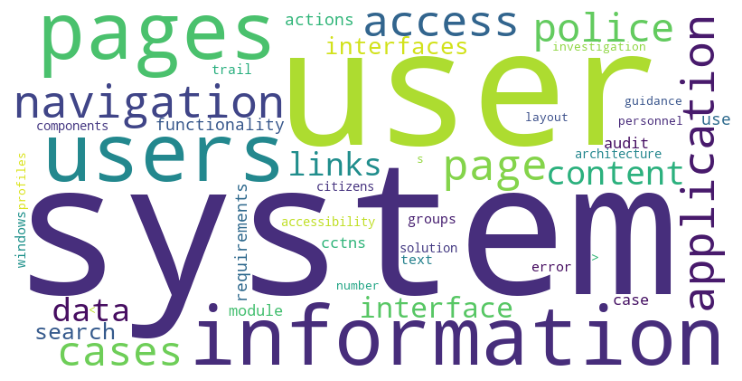

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows where 'Applicable' is True
filtered_df = concordance_df[concordance_df['Applicable'] == True]

# Create a dictionary from DataFrame index (Noun) and values (Count)
word_freq = filtered_df['Count'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 5) 
plt.show()


## Create Corpus 


In [6]:
def df_tokenized_2_corpus(df_column, min_word_freq=1):
    """
    Process a DataFrame attribute containing a list of tokenized data.

    Parameters:
    - df_column (pandas.Series): DataFrame column containing a list of tokenized data.
    - min_word_freq (int): minimum word frequency

    Returns:
    - processed_corpus (list of lists): Processed corpus after filtering based on word frequencies.
    """
    # Count word frequencies
    from collections import defaultdict
    frequency = defaultdict(int)
    
    # Count word frequencies
    for text_list in df_column:
        for token in text_list:
            frequency[token] += 1

    # Only keep words that appear more than once
    processed_corpus = [[token for token in text_list if frequency[token] > min_word_freq] for text_list in df_column]
    
    return processed_corpus

# Example usage:
corpus = df_tokenized_2_corpus(df['text_clean'], 2)
pprint.pprint(corpus)

[['e', 'mode'],
 ['crime', 'crimin', 'track', 'network', 'system', 'cctn'],
 ['function', 'requir', 'specif', 'v1', '0'],
 ['home'],
 ['1', '0'],
 [],
 ['function',
  'requir',
  'specif',
  'report',
  'provid',
  'detail',
  'descript',
  'function',
  'requir',
  'version',
  'cctn',
  'key',
  'guid',
  'principl',
  'function',
  'design',
  'cctn',
  'v1',
  '0',
  'critic',
  'function',
  'provid',
  'valu',
  'polic',
  'personnel',
  'cut',
  'turn',
  'improv',
  'area',
  'investig',
  'crime',
  'crimin'],
 ['function', 'overview'],
 ['cctn',
  'v1',
  '0',
  'function',
  'design',
  'valu',
  'record',
  'citizen',
  'within',
  'crime',
  'investig',
  'area',
  'base',
  'guid',
  'principl',
  'state',
  'differ',
  'function',
  'block',
  'identifi',
  'detail',
  'function',
  'block'],
 ['descript', 'modul', 'function', 'requir'],
 ['function',
  'cctn',
  'applic',
  'provid',
  'valu',
  'polic',
  'personnel',
  'oper',
  'cut',
  'eas',
  'day',
  'day',
  'op

## Dictionary

In [7]:
from gensim import corpora

def corpus_2_dictionary(corpus):
    """
    Associate each word in the corpus with a unique integer ID
    This dictionary defines the vocabulary of all words that our processing knows about.

    Parameters:
    - corpus (str): A list of input text to be indexed.


    Returns:
    - A dictionary of unique tokes with an associated ID
    """
    return corpora.Dictionary(corpus)

dictionary = corpus_2_dictionary(corpus)
pprint.pprint(dictionary.token2id)



{'0': 8,
 '1': 14,
 '2': 269,
 '20': 193,
 '3': 246,
 '9241': 190,
 'abil': 69,
 'abl': 147,
 'accept': 109,
 'access': 126,
 'account': 210,
 'achiev': 143,
 'act': 48,
 'action': 114,
 'activ': 140,
 'adapt': 249,
 'addit': 100,
 'administr': 129,
 'advanc': 70,
 'alert': 95,
 'allow': 152,
 'also': 71,
 'altern': 197,
 'applic': 43,
 'appropri': 151,
 'architectur': 270,
 'area': 15,
 'attempt': 148,
 'attribut': 110,
 'audit': 128,
 'avail': 144,
 'avoid': 213,
 'base': 34,
 'behaviour': 250,
 'block': 35,
 'browser': 127,
 'cach': 283,
 'capabl': 130,
 'capac': 263,
 'care': 241,
 'case': 64,
 'categori': 124,
 'cctn': 2,
 'certain': 211,
 'chang': 157,
 'citizen': 36,
 'clear': 203,
 'clearli': 225,
 'click': 183,
 'color': 238,
 'colour': 185,
 'common': 174,
 'commun': 237,
 'complaint': 49,
 'compon': 248,
 'configur': 99,
 'connect': 276,
 'consist': 244,
 'contain': 222,
 'content': 186,
 'context': 115,
 'control': 149,
 'core': 271,
 'court': 65,
 'creat': 101,
 'crime': 3

## BOW

In [8]:
bow_corpus = [dictionary.doc2bow(text) for text in corpus]
pprint.pprint(bow_corpus)

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1)],
 [(8, 1), (14, 1)],
 [],
 [(2, 2),
  (3, 1),
  (4, 1),
  (8, 1),
  (9, 4),
  (10, 2),
  (11, 1),
  (12, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(9, 1), (33, 1)],
 [(2, 1),
  (3, 1),
  (8, 1),
  (9, 3),
  (12, 1),
  (15, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (23, 1),
  (27, 1),
  (31, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(9, 1), (10, 1), (18, 1), (42, 1)],
 [(2, 1),
  (9, 2),
  (17, 1),
  (25, 1),
  (26, 2),
  (28, 1),
  (31, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2)],
 [(47, 1)],
 [(23, 1),
  (26, 4),
  (34, 1),
  (36, 2),
  (42, 1),
  (45, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (5

# Model

## TFIDF
TF-IDF is an information retrieval technique that weighs a term’s frequency (TF) and its inverse document frequency (IDF). Each word has its respective TF and IDF score. The product of the TF and IDF scores of a word is called the TFIDF weight of that word.

Put simply, the higher the TFIDF score (weight), the rarer the word and vice versa.

Among the words, tf-idf gives the highest weight to the rarer words. This is how to use the tf-idf to indicate the importance of words or terms inside a collection of documents.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Calculate TF-IDF

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text in df to compute TF-IDF scores
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# get idf values and feature names
print('\nidf values:')
for ele1, ele2 in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_):
    print(ele1, ':', ele2)





idf values:
00 : 5.350277936359301
10 : 4.944812828251137
110 : 5.350277936359301
12 : 5.350277936359301
14 : 5.350277936359301
14915 : 5.350277936359301
15 : 4.944812828251137
16 : 5.350277936359301
17 : 5.350277936359301
171 : 4.944812828251137
20 : 4.657130755799356
303 : 5.350277936359301
9241 : 4.097514967863933
a1 : 5.350277936359301
a7 : 5.350277936359301
ability : 4.944812828251137
able : 3.5585184671312464
about : 4.251665647691191
above : 5.350277936359301
acceptable : 4.944812828251137
acceptance : 5.350277936359301
access : 2.9523826635609307
accessed : 4.657130755799356
accessibility : 4.657130755799356
accessible : 4.657130755799356
accompanied : 5.350277936359301
according : 5.350277936359301
account : 4.251665647691191
accused : 5.350277936359301
achieved : 4.944812828251137
achieving : 4.944812828251137
acknowledgements : 5.350277936359301
act : 5.350277936359301
acted : 5.350277936359301
action : 4.433987204485146
actions : 3.740840023925201
activated : 5.35027793635

In [10]:
# Rename the index column to "Noun"
#concordance_df = concordance_df.rename_axis('Noun')

# Get feature names (words) from TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out().tolist()

# Step 2: Calculate TF-IDF scores for each noun in concordance_df['Noun']

# Create a new column 'TF-IDF_score' in concordance_df and initialize it with NaN
concordance_df['TF-IDF_score'] = float(0)

# Iterate over each row in the DataFrame
for noun, row in concordance_df.iterrows():
    # Check if the noun is present in the feature names
    if noun in feature_names:
        # Get the index of the noun in the feature names
        index_ = feature_names.index(noun)
        # Get the TF-IDF score for the noun from the TF-IDF matrix
        tfidf_score = tfidf_matrix[:, index_].toarray().mean()  # Take the mean TF-IDF score across all documents
        # Update the corresponding cell in the 'TF-IDF_score' column with the TF-IDF score
        concordance_df.at[noun, 'TF-IDF_score'] = tfidf_score

# Display the updated DataFrame
print(concordance_df)

               Count  Applicable  TF-IDF_score
Noun                                          
system            80        True      0.058058
user              60        True      0.047016
information       28        True      0.015722
users             28        True      0.021410
pages             27        True      0.017279
...              ...         ...           ...
item               1       False      0.001200
entry              1       False      0.001200
persistent         1       False      0.001200
administrator      1       False      0.002352
indexes            1       False      0.000532

[567 rows x 3 columns]


In [11]:
def set_applicable_false(concordance_df, words):
    """
    Set the 'Applicable' column to False for the given word(s) in the DataFrame.

    Parameters:
    - concordance_df: DataFrame containing the 'Applicable' column
    - words: A single word or a list of words to set 'Applicable' to False
    """
    # If a single word is provided, convert it to a list
    if not isinstance(words, list):
        words = [words]

    # Iterate over the words and set 'Applicable' to False
    for word in words:
        concordance_df.loc[word, 'Applicable'] = False

# Example usage:
# If you want to set 'Applicable' to False for multiple words, provide them as a list
words_to_exclude = ['user', 'system', 'access','application','module','functionality','navigation','interface','page','text','data']
set_applicable_false(concordance_df, words_to_exclude)


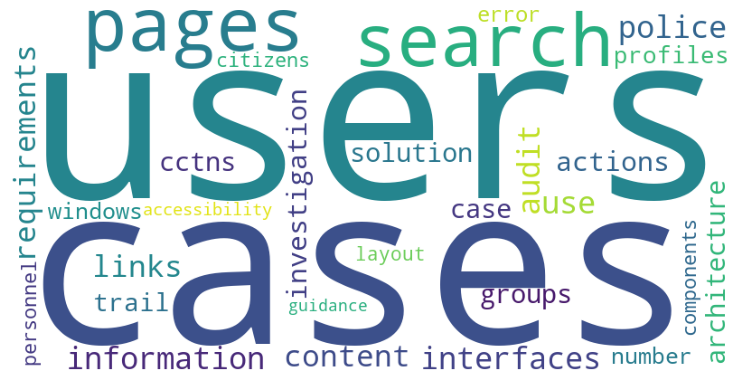

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows where 'Applicable' is True
filtered_df = concordance_df[concordance_df['Applicable'] == True]

# Create a dictionary from DataFrame index (Noun) and values (TF-IDF_score)
word_freq = filtered_df['TF-IDF_score'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 5) 
plt.show()


## Vectorization
N-Grams is captures norms in context “ISO 924114”.

###  CountVectorizer

In [13]:
df.head()

,tag,text,id,path,text_clean,POS
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title,"[e, govern, mission, mode, project, mmp]","[(e-governance, ADJ), (mission, NOUN), (mode, ..."
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title,"[crime, crimin, track, network, system, cctn]","[(crime, NOUN), (&, CONJ), (criminal, ADJ), (t..."
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title,"[function, requir, specif, v1, 0, draft]","[(functional, ADJ), (requirements, NOUN), (spe..."
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title,"[ministri, home, affair, govern, india]","[(ministry, NOUN), (of, ADP), (home, NOUN), (a..."
4,version,1.0,,req_document/version,"[1, 0]","[(1.0, NUM)]"


In [14]:
from utils import clean_data
from sklearn.feature_extraction.text import CountVectorizer


# Analysier paramether we can pass a function to clean the text
count_vect = CountVectorizer(analyzer=clean_data.clean_text_original)
X_counts = count_vect.fit_transform(df['text'])

# This will output ("how many rows where analysied", "How many unique words there are")
print(X_counts.shape)
print(count_vect.get_feature_names_out())

# FIXME:  individual characters being tokenized as features.

(154, 37)
[' ' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g'
 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y'
 'z']


### Vectorizers output sparse matrices

X_counts_sample is a _**Sparse Matrix**: A matrix in which most entries are 0. In the interest of efficient storage, a sparse matrix will be stored by only storing the locations of the non-zero elements._

In [15]:
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,4,0,0,0,0,0,0,0,0,0,...,0,2,2,1,0,1,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,4,2,4,0,0,1,0,1,0
2,4,1,1,0,0,0,0,0,0,0,...,1,3,1,2,2,1,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,3,1,1,0,1,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,3,0,0,0,0,0,0,0,0,0,...,0,3,3,2,2,0,1,0,1,0
150,5,0,0,0,0,0,0,0,0,0,...,0,3,5,6,1,0,0,0,2,0
151,10,0,0,1,0,0,0,0,0,0,...,0,5,10,7,4,0,2,0,2,0
152,39,0,0,0,0,0,0,0,0,0,...,4,22,20,22,10,5,2,0,1,0


### Vectorizing Raw Data: N-Grams

In [16]:
df['text_clean2string'] = df['text'].apply(lambda x: clean_data.clean_text_2string(x))
df.head()

,tag,text,id,path,text_clean,POS,text_clean2string
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title,"[e, govern, mission, mode, project, mmp]","[(e-governance, ADJ), (mission, NOUN), (mode, ...",egovern mission mode project mmp
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title,"[crime, crimin, track, network, system, cctn]","[(crime, NOUN), (&, CONJ), (criminal, ADJ), (t...",crime crimin track network system cctn
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title,"[function, requir, specif, v1, 0, draft]","[(functional, ADJ), (requirements, NOUN), (spe...",function requir specif v10 draft
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title,"[ministri, home, affair, govern, india]","[(ministry, NOUN), (of, ADP), (home, NOUN), (a...",ministri home affair govern india
4,version,1.0,,req_document/version,"[1, 0]","[(1.0, NUM)]",10


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# (x,y) are the start and end point of n-grams capturing
# (1,1) only unigrams
# (1,2) unigrams and bigrams
# (1,3) unigrams, bigrams and trigrams
# ...
ngram_vect = CountVectorizer(ngram_range=(1,3))
X_counts = ngram_vect.fit_transform(df['text_clean2string'])
print(X_counts.shape)
print(ngram_vect.get_feature_names_out())

(154, 5380)
['10' '10 20' '10 20 maximum' ... 'xx00 xx00' 'xx00 xx00 weekdaysxxx'
 'year']


In [18]:
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.columns = ngram_vect.get_feature_names_out()
X_counts_df

,10,10 20,10 20 maximum,10 shall,10 shall standard,1015,1015 second,1015 second regardless,149151,149151 iso,...,xx hour,xx hour per,xx hoursminut,xx hoursminut per,xx00,xx00 weekdaysxxx,xx00 weekdaysxxx day,xx00 xx00,xx00 xx00 weekdaysxxx,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Vectorizing Raw Data: TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_data.clean_text_2stem)
X_tfidf = tfidf_vect.fit_transform(df['text'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names_out())

(154, 834)
['' '10' '1015' '149151' '149153' '2' '20' '2way' '3' '3tier' '4' '58'
 '9241' '9241110' '924112' '924114' '924115' '924116' '924117' '9241171'
 '924120' '9241303' 'a1' 'a7' 'abil' 'abl' 'accept' 'access' 'accompani'
 'accord' 'account' 'achiev' 'acknowledg' 'act' 'action' 'activ' 'adapt'
 'add' 'addit' 'address' 'adequ' 'administr' 'adminus' 'admiss' 'adopt'
 'advanc' 'affair' 'affect' 'age' 'agent' 'aggress' 'aid' 'ajax' 'alert'
 'alloc' 'allow' 'also' 'altern' 'amount' 'analys' 'andor' 'anoth'
 'appear' 'appli' 'applic' 'approach' 'appropri' 'architectur' 'area'
 'around' 'arrang' 'assign' 'assist' 'associ' 'asynchron' 'attempt'
 'attribut' 'audit' 'auditor' 'authent' 'authoris' 'autom' 'automat'
 'avail' 'avoid' 'back' 'background' 'bandwidth' 'base' 'basic' 'batch'
 'batchespag' 'becom' 'behaviour' 'behind' 'better' 'block' 'bookmark'
 'broad' 'browser' 'browserbas' 'built' 'bullet' 'busi' 'button' 'c'
 'cach' 'capabl' 'capac' 'captur' 'care' 'carri' 'case' 'cast' 'cate

In [20]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names_out()
X_tfidf_df

,,10,1015,149151,149153,2,20,2way,3,3tier,...,without,work,workstat,would,write,wwwusabilitygov,x,xx,xx00,year
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.354627,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Gensim Compare

In [21]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "system requirements".lower().split()
print(tfidf[dictionary.doc2bow(words)])

[(6, 1.0)]


The ``tfidf`` model again returns a list of tuples, where the first entry is
the token ID and the second entry is the tf-idf weighting. The words that occur
more times are weighted lower.

You can save trained models to disk and later load them back, either to
continue training on new training documents or to transform new documents.

``gensim`` offers a number of different models/transformations.
For more, see `sphx_glr_auto_examples_core_run_topics_and_transformations.py`.

Once you've created the model, you can do all sorts of cool stuff with it.
For example, to transform the whole corpus via TfIdf and index it, in
preparation for similarity queries:




In [22]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=12)

and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [23]:
query_document = 'system engineering'.split()
query_bow = dictionary.doc2bow(query_document)
pprint.pprint(query_bow)

[(6, 1)]


## Transforming vectors
From now on, tfidf is treated as a read-only object that can be used to convert any vector from the old representation (bag-of-words integer counts) to the new representation (TfIdf real-valued weights).
Once the transformation model has been initialized, it can be used on any vectors (provided they come from the same vector space, of course), even if they were not used in the training corpus at all. This is achieved by a process called folding-in for LSA, by topic inference for LDA etc.

In [24]:
from gensim import models
tfidf = models.TfidfModel(bow_corpus)
lsi = models.LsiModel(bow_corpus, id2word=dictionary, num_topics=2)




Now suppose a user typed in the query “Human computer interaction”. We would like to sort our nine corpus documents in decreasing order of relevance to this query. Unlike modern search engines, here we only concentrate on a single aspect of possible similarities—on apparent semantic relatedness of their texts (words). No hyperlinks, no random-walk static ranks, just a semantic extension over the boolean keyword match:

In [25]:
doc = "Human computer interaction"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
print(vec_lsi)

[(0, -0.014386862211931157), (1, -0.040010367509536744)]


In addition, we will be considering cosine similarity to determine the similarity of two vectors. Cosine similarity is a standard measure in Vector Space Modeling, but wherever the vectors represent probability distributions, different similarity measures may be more appropriate.


### Initializing query structures
To prepare for similarity queries, we need to enter all documents which we want to compare against subsequent queries. In our case, they are the same nine documents used for training LSI, converted to 2-D LSA space. But that’s only incidental, we might also be indexing a different corpus altogether.



In [26]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it

pprint.pprint(index)

### Performing queries

To obtain similarities of our query document against the nine indexed documents:

In [28]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
# pprint.pprint(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

sims = sorted(enumerate(sims), key=lambda item: -item[1])
for doc_position, doc_score in sims:
    print(doc_score, corpus[doc_position])
   


0.9999739 ['distinguish', 'within', 'page', 'link', 'within', 'page', 'link', 'clearli', 'distinguish', 'link', 'differ', 'page', 'within', 'page', 'link', 'shown']
0.99985105 ['home']
0.9997207 ['avoid', 'link', 'text', 'page', 'contain', 'larg', 'link', 'format', 'link', 'imped', 'readabl', 'text']
0.9980657 ['place', 'titl', 'inform', 'consist', 'page', 'titl', 'place', 'consist', 'differ', 'page']
0.99778265 ['place', 'navig', 'compon', 'consist', 'navig', 'compon', 'place', 'consist', 'page', 'page', 'applic']
0.99707174 ['readabl', 'text', 'text', 'present', 'page', 'readabl', 'take', 'account', 'expect', 'display', 'iso', '9241', 'shall', 'screen', 'text', 'requir']
0.99345773 ['support', 'text', 'skim', 'skim', 'text', 'support', 'clear', 'link', 'list', 'logic', 'short']
0.9929931 ['1', '0']
0.99053794 ['use', 'white', 'space', 'white', 'space', 'page', 'e', 'space', 'color', 'use', 'way', 'skim', 'page', 'white', 'space', 'import', 'mean', 'differ', 'content', 'element', 'pag